1. preprocess - done
2. ML model - logistice regresion - done
3. anlyeze the model
4. get concluse

In [82]:
!pip -q install shap

In [83]:
# Standard library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# Scikit-learn: preprocessing & pipelines
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression

# Scikit-learn: model selection
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
    learning_curve
)

# Scikit-learn: evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)




## Load and Inspect Dataset

We begin by loading the **Heart Attack Prediction** dataset from Kaggle.  
The dataset is stored under `/kaggle/input/heart-attack-prediction/`.



In [84]:
heart_attack_df = pd.read_csv("/kaggle/input/heart-attack-prediction/data.csv")

In [85]:

print("Shape of dataset:", heart_attack_df.shape)
print("First 20 rows:")
display(heart_attack_df.head(20))

Shape of dataset: (294, 14)
First 20 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0
5,32,0,2,105,198,0,0,165,0,0.0,?,?,?,0
6,32,1,2,110,225,0,0,184,0,0.0,?,?,?,0
7,32,1,2,125,254,0,0,155,0,0.0,?,?,?,0
8,33,1,3,120,298,0,0,185,0,0.0,?,?,?,0
9,34,0,2,130,161,0,0,190,0,0.0,?,?,?,0


## Handling Question Mark Values

Some columns in the dataset contain `"?"` as a placeholder for missing values.  
To understand their impact, we calculate both the **count** and **percentage** of `"?"` entries per column.



In [86]:
# Total rows in your dataset
total_rows = 294  

# Create a summary DataFrame
question_mark_summary = pd.DataFrame({
    "Column": heart_attack_df.columns,
    "QuestionMark_Count": [
        (heart_attack_df[col] == "?").sum() for col in heart_attack_df.columns
    ]
})

# Add percentage column
question_mark_summary["QuestionMark_Percent"] = (
    question_mark_summary["QuestionMark_Count"] / total_rows * 100
).round(2)

print(question_mark_summary)


        Column  QuestionMark_Count  QuestionMark_Percent
0          age                   0                  0.00
1          sex                   0                  0.00
2           cp                   0                  0.00
3     trestbps                   1                  0.34
4         chol                  23                  7.82
5          fbs                   8                  2.72
6      restecg                   1                  0.34
7      thalach                   1                  0.34
8        exang                   1                  0.34
9      oldpeak                   0                  0.00
10       slope                 190                 64.63
11          ca                 291                 98.98
12        thal                 266                 90.48
13  num                          0                  0.00


In [87]:
cols_to_drop = ["slope", "ca", "thal"]
heart_attack_df = heart_attack_df.drop(columns=cols_to_drop)

print("Remaining columns:")
print(heart_attack_df.columns)

Remaining columns:
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'num       '],
      dtype='object')


## Cleaning Column Names

Some CSV files may include extra spaces around column names (e.g., `" age "` instead of `"age"`).  
To ensure clean and consistent column references, we strip all leading/trailing whitespace from column names.


In [88]:
# Strip whitespace from column names
heart_attack_df.columns = heart_attack_df.columns.str.strip()

print("Cleaned column names:")
print(list(heart_attack_df.columns))


Cleaned column names:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'num']


## Final Feature Set

After preprocessing (cleaning missing values, dropping unusable columns, and creating a binary target),  
the following columns remain for modeling:

| Column      | Description                                                                 |
|-------------|-----------------------------------------------------------------------------|
| **age**     | Age in years                                                                |
| **sex**     | Sex (1 = male, 0 = female)                                                  |
| **cp**      | Chest pain type:<br>1 = typical angina<br>2 = atypical angina<br>3 = non-anginal pain<br>4 = asymptomatic |
| **trestbps**| Resting blood pressure (mm Hg)                                              |
| **chol**    | Serum cholesterol (mg/dl)                                                   |
| **fbs**     | Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)                       |
| **restecg** | Resting electrocardiographic results:<br>0 = normal<br>1 = ST-T wave abnormality<br>2 = left ventricular hypertrophy |
| **thalach** | Maximum heart rate achieved                                                 |
| **exang**   | Exercise induced angina (1 = yes, 0 = no)                                   |
| **oldpeak** | ST depression induced by exercise relative to rest                          |
| **num**     | Diagnosis of heart disease severity (0 = no disease, 1–4 = levels of severity) |
| **heart_attack** | **Binary target column** (0 = no disease, 1 = heart disease present)    |

---

### Outcome
- Kept clinically relevant features for prediction.  
- Preserved the original `num` column (multi-class severity) **and** added a binary `heart_attack` target for classification tasks.  
- Dataset is now ready for exploratory analysis and model training.


## Data Preparation and Preprocessing Pipeline

We now prepare the dataset for modeling by creating a binary target, separating features,  
handling missing values, and defining preprocessing pipelines for numeric and categorical variables.



In [90]:
# Create new binary column: 0 = no heart attack, 1 = heart attack
heart_attack_df['heart_disease'] = (heart_attack_df['num'] > 0).astype(int)

# Separate features and target
X = heart_attack_df.drop(['num', 'heart_disease'], axis=1)
y = heart_attack_df['heart_disease']



In [91]:
print(f" Target distribution:")
print(y.value_counts())
print(f"Baseline accuracy: {max(y.value_counts(normalize=True)):.3f}")

 Target distribution:
heart_disease
0    188
1    106
Name: count, dtype: int64
Baseline accuracy: 0.639


In [92]:
# Replace "?" with NaN everywhere
X = X.replace("?", np.nan)

# -----------------------------------------
# 1) Explicit column lists (based on your final set)
# -----------------------------------------
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang"]

# If any of the numeric columns were read as strings, coerce them safely
for col in numeric_features:
    X[col] = pd.to_numeric(X[col], errors="coerce")

In [93]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop=None))  # keep all levels
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
    ],
    remainder="drop"
)

In [94]:
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced"))
])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)



Train set shape: (235, 10) (235,)
Test set shape: (59, 10) (59,)


## Model Evaluation: Cross-Validation and Learning Curves

To assess model performance on a small dataset, we use **5-fold Stratified Cross-Validation**  
with multiple metrics, followed by evaluation on the **hold-out test set**.  
Finally, we generate a **learning curve** to analyze potential overfitting or underfitting.

---

### Cross-Validation (5-fold)
We evaluate the model across several metrics:  
- **Accuracy**: overall correctness  
- **Precision**: proportion of positive predictions that are correct  
- **Recall**: proportion of actual positives detected  
- **F1**: harmonic mean of precision and recall  
- **ROC-AUC**: ability to rank positives above negatives

In [95]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate multiple metrics to get a fuller picture on small data
scorings = ["accuracy", "precision", "recall", "f1", "roc_auc"]
cv_results = {}
for metric in scorings:
    scores = cross_val_score(clf, X, y, cv=cv, scoring=metric)
    cv_results[metric] = (scores.mean(), scores.std())

print("Cross-Validation (5-fold):")
for metric, (mean_, std_) in cv_results.items():
    print(f"{metric:9s}: {mean_:.3f} ± {std_:.3f}")

# -----------------------------------------
# 5) Train on full training data and test
# -----------------------------------------
# Fit on the training set only (assuming you have X_train, X_test)
clf.fit(X_train, y_train)
print("\nHold-out Test Metrics:")


y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("accuracy :", accuracy_score(y_test, y_pred).round(3))
print("precision:", precision_score(y_test, y_pred).round(3))
print("recall   :", recall_score(y_test, y_pred).round(3))
print("f1       :", f1_score(y_test, y_pred).round(3))
print("roc_auc  :", roc_auc_score(y_test, y_prob).round(3))

Cross-Validation (5-fold):
accuracy : 0.800 ± 0.062
precision: 0.715 ± 0.091
recall   : 0.745 ± 0.089
f1       : 0.729 ± 0.085
roc_auc  : 0.889 ± 0.036

Hold-out Test Metrics:
accuracy : 0.847
precision: 0.773
recall   : 0.81
f1       : 0.791
roc_auc  : 0.934


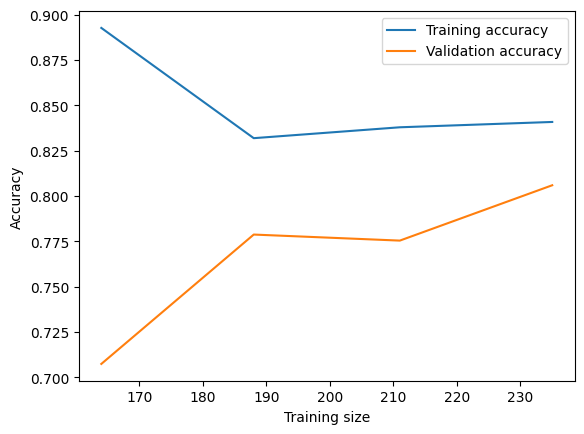

In [96]:
train_sizes, train_scores, val_scores = learning_curve(
    clf, X, y, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, val_mean, label="Validation accuracy")
plt.xlabel("Training size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## SHAP Graphs Analysis

We used SHAP to interpret the logistic regression model.  
Below are the three main plots and their insights.

---

### 1. Beeswarm Plot – Global Feature Impact & Direction
- **oldpeak**: higher values → strong push toward heart disease.  
- **cp_2 (atypical angina)**: protective, reduces risk.  
- **cp_4 (asymptomatic chest pain)**: increases risk.  
- **sex (male)**, **age**, **cholesterol**: moderately increase risk.  
- **thalach (max heart rate)**: higher values reduce risk.  
- **exang (exercise-induced angina)**: presence increases risk.  

Takeaway: **exercise-related features** (oldpeak, thalach, exang) and **chest pain type** dominate the predictions.

---

### 2. Bar Plot – Mean Absolute Importance
- Confirms the same ranking: **oldpeak, cp_2, cp_4, cholesterol** are the top predictors.  
- Demographics (sex, age) and exercise-induced angina also matter.  
- Features like **restecg, fbs, trestbps** have smaller effect.  

Takeaway: Ranking is consistent with beeswarm → model is stable in what it learns.

---

### 3. Waterfall Plot – Single Patient Explanation
For one patient, prediction leaned toward **no heart disease**:
- **cp_2** strongly reduced risk (−0.86).  
- **oldpeak** increased risk (+0.55).  
- **cp_4** reduced risk (−0.46).  
- **age, sex, cholesterol** slightly increased risk.  
- **no exercise-induced angina** and higher **thalach** reduced risk.  

Takeaway: For this individual, the protective effect of **cp_2** outweighed other risk factors.

---

### Overall Notes
- **Global view**: model relies mainly on **oldpeak, chest pain type, sex, age, cholesterol**.  
- **Local view**: chest pain type and exercise features can completely shift predictions.  
- **Sanity check**: results align with medical knowledge, suggesting the model is learning meaningful patterns.


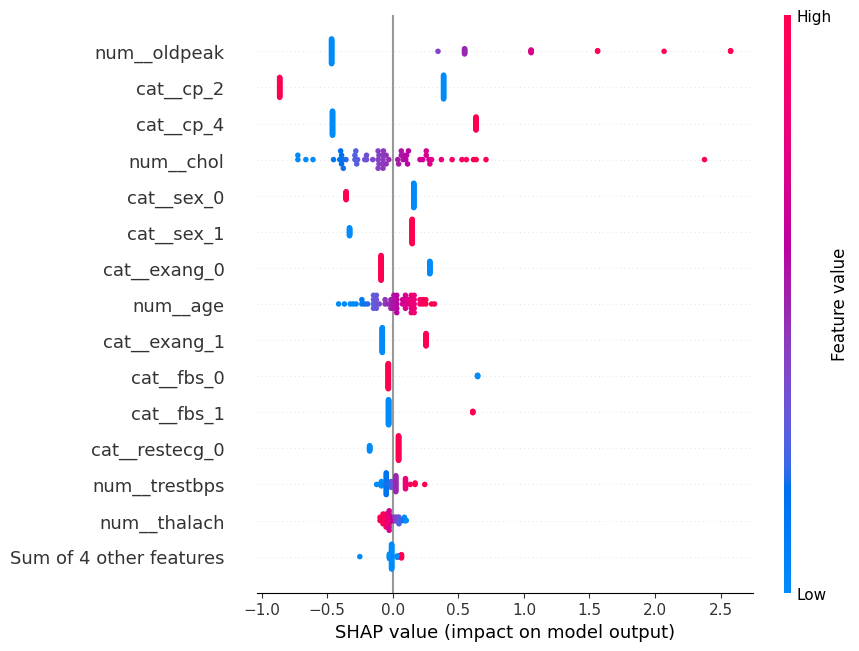

In [107]:
prep  = clf.named_steps["prep"]
model = clf.named_steps["model"]

# Transform train/test to the model's feature space
X_train_t = prep.transform(X_train)
X_test_t  = prep.transform(X_test)

# Get the post-transform feature names (includes one-hots)
feature_names = prep.get_feature_names_out()

# For SHAP, pass a DataFrame so names are preserved in the Explanation
X_train_t_df = pd.DataFrame(X_train_t, columns=feature_names)
X_test_t_df  = pd.DataFrame(X_test_t,  columns=feature_names)

# Build masker & explainer (for linear models)
masker    = shap.maskers.Independent(X_train_t_df)
explainer = shap.explainers.Linear(model, masker)

# Compute SHAP values for the test set
shap_values = explainer(X_test_t_df)   # shap.Explanation with feature names attached

# ==========================
# 7) Global importance plots
# ==========================
# Beeswarm: distribution + direction of impact
shap.plots.beeswarm(shap_values, max_display=15)


## SHAP Beeswarm Analysis (Global Feature Impact)

This plot shows how each feature contributes to the prediction of **heart disease** (positive SHAP values) or **no heart disease** (negative SHAP values).  
Each dot represents one patient; color = feature value (blue = low, red = high).

---

### Key Findings

1. **oldpeak (ST depression induced by exercise)**  
   - Higher values (red) strongly increase the risk of heart disease.  
   - Lower values (blue) are associated with no disease.  
   - Clinically: ST depression during exercise is a classic marker of ischemia.

2. **Chest Pain Type (cp)**  
   - `cp_2` (atypical angina): presence tends to reduce predicted risk.  
   - `cp_4` (asymptomatic): presence strongly increases predicted risk.  
   - Interpretation: asymptomatic cases are riskier, while atypical angina is less predictive of disease.

3. **chol (serum cholesterol)**  
   - Higher cholesterol values sometimes push predictions toward disease, but the effect is weaker and more mixed compared to oldpeak or cp.

4. **sex**  
   - `sex=1` (male) → higher predicted risk.  
   - `sex=0` (female) → lower predicted risk.

5. **exang (exercise-induced angina)**  
   - `exang=1` (yes) → increases predicted risk.  
   - `exang=0` (no) → decreases predicted risk.

6. **age**  
   - Older patients (red) are more likely to be classified as having disease.  
   - Younger patients (blue) push predictions toward no disease.

7. **thalach (maximum heart rate achieved)**  
   - Higher heart rates (red) reduce predicted risk.  
   - Lower heart rates (blue) increase predicted risk.

---

### Conclusion
The model emphasizes **exercise-related features (oldpeak, exang, thalach)** and **chest pain types** as the strongest predictors, aligning well with medical knowledge.  
Demographics (sex, age) and cholesterol also contribute, though with weaker or more mixed influence.


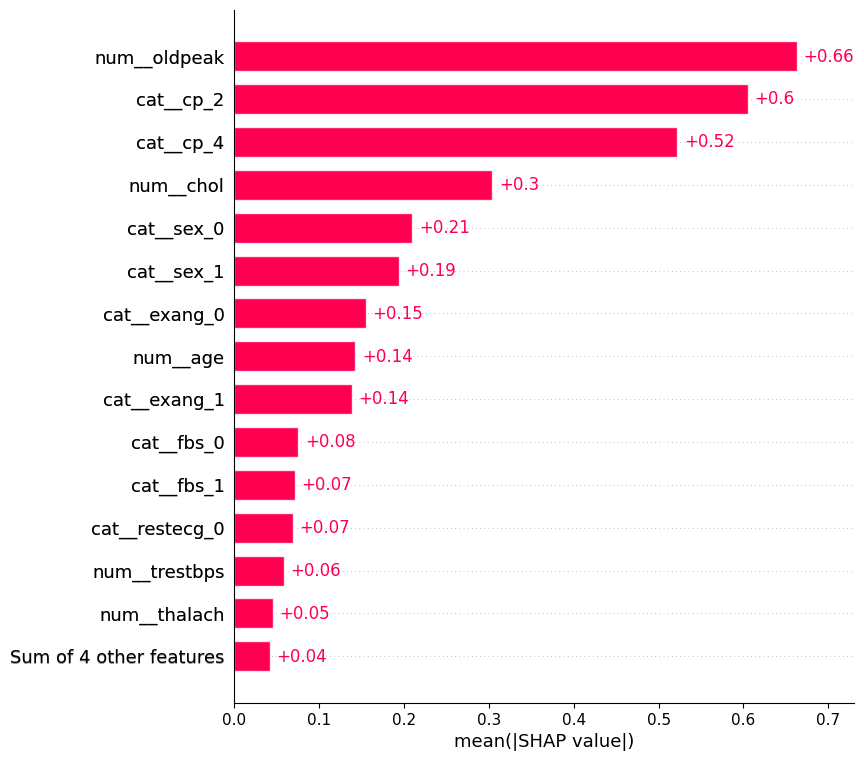

In [108]:
# Bar: mean(|SHAP|) per feature
shap.plots.bar(shap_values, max_display=15)




## SHAP Bar Plot Analysis (Mean Absolute Impact)

This plot ranks features by their **average contribution** to the model’s output, regardless of whether the effect is positive or negative.  
Higher bars = stronger overall influence on predictions.

---

### Top Predictors

1. **oldpeak (0.66)**  
   - The most important predictor.  
   - Reflects ST depression during exercise — strongly linked to heart disease risk.

2. **cp_2 (0.60)**  
   - Chest pain type: *atypical angina*.  
   - Highly influential, though its effect direction (protective vs. risky) is seen in the beeswarm plot.

3. **cp_4 (0.52)**  
   - Chest pain type: *asymptomatic*.  
   - Strongly associated with increased risk when present.

4. **chol (0.30)**  
   - Cholesterol has a moderate but consistent influence.  
   - Less decisive than exercise-related measures, but still meaningful.

---

### Secondary Predictors

- **sex (0.21 for female, 0.19 for male)**  
  Gender plays a clear role in prediction, with males more likely to be classified as at risk.  

- **exang (0.15)**  
  Exercise-induced angina is an important exercise-response marker.  

- **age (0.14)**  
  Older age increases risk, consistent with medical intuition.  

---

### Lower Influence Features

- **fbs, restecg, trestbps, thalach** each have relatively small average impacts (<0.1).  
- While clinically relevant, they are not strong differentiators in this dataset compared to exercise-related measures and chest pain types.

---

### Conclusion
The bar plot confirms the findings from the beeswarm:  
- **Exercise response (oldpeak, exang, thalach)** and **chest pain type (cp_2, cp_4)** dominate the model’s predictions.  
- Demographics (sex, age) and cholesterol also contribute meaningfully.  
- Other features (fbs, restecg, resting BP) play a minor role.


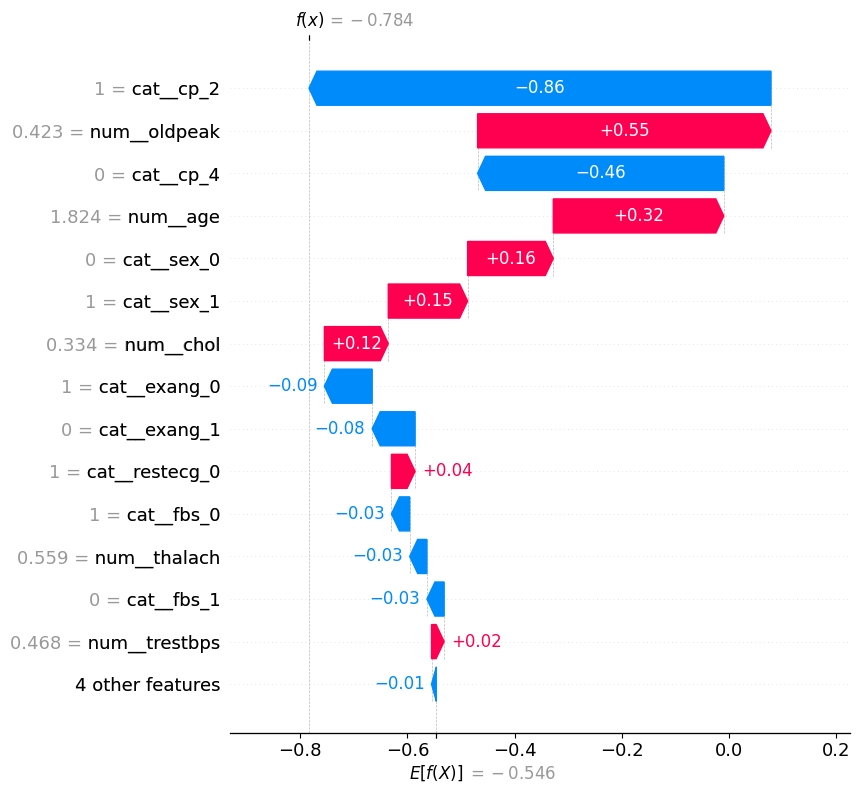

In [110]:
# ==========================================
# 8) Single-instance explanation (waterfall)
# ==========================================
i = 0  # choose any index from 0..len(X_test)-1
shap.plots.waterfall(shap_values[i], max_display=15)


## SHAP Waterfall Analysis (Single Patient Prediction)

This plot explains the contribution of each feature to one patient’s predicted risk of **heart disease**.  
The baseline (E[f(x)] = -0.546) is the average model output across all patients.  
Each bar shows how a feature pushed the prediction **upward (toward disease, red)** or **downward (toward no disease, blue)**.

---

### Key Drivers for This Patient

1. **Chest pain type = cp_2 (atypical angina)**  
   - Strongly decreases the risk (−0.86).  
   - Suggests that having atypical angina is associated with lower probability of disease.

2. **oldpeak = 0.423**  
   - Increases risk significantly (+0.55).  
   - Even moderate ST depression during exercise raises the predicted probability.

3. **Chest pain type = cp_4 (asymptomatic)**  
   - Decreases risk (−0.46).  
   - For this patient, not having asymptomatic chest pain lowers predicted probability.

4. **age = 1.824 (scaled value)**  
   - Contributes positively (+0.32).  
   - Older age increases predicted risk.

5. **sex = male (sex_1 = 1, sex_0 = 0)**  
   - Both male indicators add small positive contributions (+0.16, +0.15).  
   - Being male increases predicted risk.

6. **chol = 0.334 (scaled value)**  
   - Small positive effect (+0.12).  
   - Slightly elevated cholesterol nudges risk upward.

---

### Protective Features
- **exang=0 (no exercise-induced angina)** → reduces risk (−0.09).  
- **exang_1=0 (absence of angina episode)** → reduces risk (−0.08).  
- **thalach = 0.559 (scaled maximum heart rate achieved)** → slightly reduces risk (−0.03).  
- **fbs_0 = 1 (normal fasting blood sugar)** → reduces risk (−0.03).  

---

### Overall Prediction
- Total SHAP contributions sum to **f(x) = −0.784**, which is below the baseline.  
- This means the model **leans toward predicting no heart disease** for this patient, despite risk-increasing factors (age, oldpeak, male sex).  
- The decisive protective factor is **cp_2 (atypical angina)**, which heavily offsets the risk factors.

---

### Clinical Interpretation
For this individual, the **type of chest pain (atypical angina)** dominates the prediction, outweighing age, sex, and exercise-related indicators.  
It highlights how categorical features (symptom type) can sometimes have stronger model influence than numerical risk factors.


In [111]:
# (Optional) Quick coefficient sanity check for Logistic Regression
coef = pd.Series(model.coef_.ravel(), index=feature_names) \
         .sort_values(key=lambda s: s.abs(), ascending=False)
print("\nTop 15 absolute coefficients:")
print(coef.head(15))


Top 15 absolute coefficients:
cat__cp_2        -1.250046
cat__cp_4         1.094350
num__oldpeak      0.943484
cat__fbs_0       -0.680778
cat__fbs_1        0.642526
cat__sex_0       -0.516006
cat__sex_1        0.477754
num__chol         0.437877
cat__exang_0     -0.371956
cat__exang_1      0.333704
cat__restecg_2   -0.242566
cat__restecg_0    0.220697
num__age          0.172884
cat__cp_3         0.074902
num__trestbps     0.061780
dtype: float64


## Logistic Regression Coefficients (Top 15)

These are the largest coefficients (by absolute value).  
Positive = increases probability of **heart disease**.  
Negative = decreases probability of **heart disease**.

---

### Strongest Predictors

1. **cp_2 (atypical angina)** → **−1.25**  
   - Strongly protective factor.  
   - Patients with atypical angina are much less likely to be classified as having heart disease.

2. **cp_4 (asymptomatic)** → **+1.09**  
   - Strong positive risk factor.  
   - Asymptomatic patients are much more likely to be classified as having heart disease.

3. **oldpeak (exercise ST depression)** → **+0.94**  
   - Higher values increase risk.  
   - Consistent with exercise-induced ischemia being a key diagnostic marker.

---

### Other Influential Features

- **fbs_0 (normal fasting blood sugar)** → **−0.68**  
  Protective; normal fasting glucose reduces risk.  

- **fbs_1 (high fasting blood sugar)** → **+0.64**  
  Increases risk; high fasting glucose is a risk marker.  

- **sex_0 (female)** → **−0.52**  
  Protective; females have lower predicted risk.  

- **sex_1 (male)** → **+0.48**  
  Increases risk; males are more likely to be classified as having heart disease.  

- **chol (serum cholesterol)** → **+0.44**  
  Higher cholesterol increases risk, but effect is moderate compared to chest pain and exercise features.  

- **exang_0 (no exercise-induced angina)** → **−0.37**  
  Protective.  

- **exang_1 (exercise-induced angina present)** → **+0.33**  
  Risk-enhancing.  

---

### Weaker but Noticeable Predictors
- **restecg_2 (LV hypertrophy)** → **−0.24**  
- **restecg_0 (normal ECG)** → **+0.22**  
- **age** → **+0.17**  
- **cp_3 (non-anginal pain)** → **+0.07**  
- **trestbps (resting BP)** → **+0.06**

---

### Conclusion
- The **most influential features** are **chest pain type (cp_2, cp_4)** and **exercise response (oldpeak, exang)**.  
- Demographics (sex, age) and metabolic markers (fbs, cholesterol) play important but secondary roles.  
- This ranking matches the SHAP analyses, reinforcing that the model relies heavily on **symptom type and exercise indicators** to classify patients.
